# Exploration 11 뉴스 요약봇 만들기

# 진행순서

1. 추상적 요약
- 데이터 불러오기
- 데이터 전처리하기 (불용어 제거, 축약어 통일 등)
- 훈련데이터, 테스트데이터 분리 
- 임계치 설정 및 기준 이상 데이터 제거
- 토큰 추가
- 인덱스 섞기
- 정수 인코딩
- 빈도수에 따른 제거
- 어텐션 매커니즘 활용 (인코더, 디코더 생성, 어텐션 추가)
- 모델 훈련
- 모델 테스트
- 비교


2. 추출적 요약
- 데이터 불러오기
- 추출 비율 설정
- 비교

# 후기

아니, 생각보다 추출적 요약이 너무 안나와서 놀람..    
전처리를 하면 안나오고,      
words를 작게 해도 안나오고,    
ratio를 작게 줘도 안나오고...     

ratio를 0.5 이상으로 줘야 요약이 좀 제대로 나오는 것 같다.   
문제는 여전히 추출이 안되는 것이 있다는 거



현재 심정 한 컷 요약


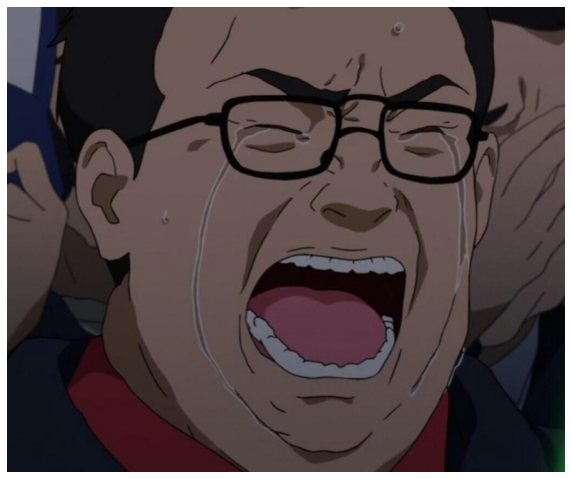

In [36]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import os

print("현재 심정 한 컷 요약")

fileName = os.getenv('HOME') + "/aiffel/최고다.JPG"
image = img.imread(fileName)
fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(image)
plt.show()

# Step 1. 데이터 수집하기

In [53]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [55]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.


### 2.1 데이터 정리
우선 중복값과 Null값, 동의어 등을 정리해준다.

In [56]:
# 중복 샘플과 Null 제거

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique()) # summary는 똑같을 수 있어

# TEXT는 중복 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

print("NULL값 : ","\n",data.isnull().sum())

# Summary에 있는 Null 값 제거

data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360
NULL값 :  
 headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


In [57]:
# 우선 같은 말인 것들을 통일해줍시다.

#  정규화용 딕셔너리 선언
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))


정규화 사전의 수:  120


In [58]:
# 불용어로 제거해봅시다. 어차피 suumary에서 불용어의 중요성은 그리 크지 않을 듯?

# 불용어 개수
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [59]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [60]:
# 텍스트 컬럼 전처리 시작!

clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [61]:
# 요약 컬럼 전처리 시작!

clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [62]:
## 전처리한 데이터를 원래 컬럼에 다시 넣어줍시다
data['text'] = clean_text
data['headlines'] = clean_summary


# 빈 값을 Null 값으로 변환 --> 밑에서 Null을 또 없앤다
data.replace('', np.nan, inplace=True)

In [63]:
# null 유무 확인

data.isnull().sum()

headlines    0
text         0
dtype: int64

In [64]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


### 2.2 훈련데이터와 테스트데이터 나누기
데이터 내부 최대길이를 조절하고, 시작토큰과 종료토큰을 추가한다.       
이후 훈련데이터와 테스트데이터를 분리한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


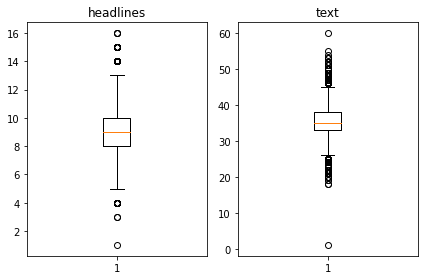

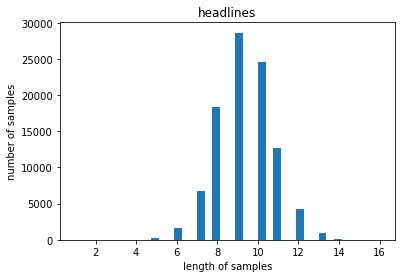

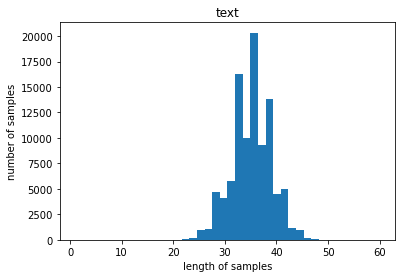

In [65]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [66]:
# 텍스트 및 요약 최대 길이 설정

text_max_len = 50
summary_max_len = 8

In [67]:
# 최대길이(임계치)이하인 샘플 비율을 알아내는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [68]:
# 최대길이 이하 샘플 비율을 출력한다

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


In [69]:
# 최대 길이 이상인 데이터는 제외한다.

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 27105


In [70]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,isro unveils bengaluru centre for manned space...,indian space research organisation wednesday u...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,killed injured in saudi arabia floods,least people killed others injured saudi arabi...,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,seat cushions from missing plane carrying foot...,investigators searching lost plane carrying ar...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland scam accused rajiv saxena extra...,agustawestland chopper scam co accused rajiv s...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


In [71]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [72]:
## encoder_input과 크기와 형태가 같은, 
# 순서가 섞인 정수 시퀀스 생성 

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 6855 23553 22630 ... 23604  4038  8526]


In [73]:
# 섞인 시퀀스로 데이터 샘플 순서 변경

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [74]:
# 훈련데이터, 테스트데이터 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 5421


In [75]:
#  테스트 데이터의 갯수를 이용해 전체 데이터를 양분

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


### 2.3 정수인코딩
이제 단어를 정수로 바꿔서 모델이 학습할 수 있도록 만들어봅시다.

In [76]:
# 토크나이저를 생성합니당

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


# 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여
# 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장

In [77]:
# 등장빈도가 7회 이하인 단어가 얼마나 많은 비중을 차지하는지 확인해봅시다.

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42578
등장 빈도가 6번 이하인 희귀 단어의 수: 30814
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11764
단어 집합에서 희귀 단어의 비율: 72.37070787730752
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.283885215516674


In [78]:
## 제외한 뒤 단어집합의 크기가 8222개
# 대충 단어집합의 크기를 8000개로 설정해봅시다.

src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [79]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 
# 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 앞의 3개를 샘플로 출력
print(encoder_input_train[:3]) # 정수로 출력

[[61, 17, 2557, 7080, 33, 101, 10, 139, 140, 1062, 10, 139, 140, 77, 556, 299, 1940, 149, 289, 149, 289, 7793, 223, 1828, 177, 595, 1705, 1509, 582], [113, 23, 102, 499, 1063, 544, 855, 5226, 373, 75, 5398, 325, 717, 45, 801, 299, 1213, 544, 32, 40, 26, 1904, 1063, 12, 855, 373, 73, 27, 349], [28, 2433, 243, 2588, 786, 2388, 12, 149, 394, 5227, 31, 29, 5227, 403, 737, 170, 218, 30, 6469, 1009, 910, 2389, 2244, 6470, 952, 85, 986, 7411, 1318, 987, 7794]]


In [80]:
# 텍스트 컬럼 뿐만 아니라 요약에도 해줘야지

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train) # decoder_input_train을 넣는다


#단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여
#이는 tar_tokenizer.word_index에 저장
#tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장

In [81]:
# 등장 빈도가 6회 미만인 단어가 얼만큼의 비중인지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18860
등장 빈도가 5번 이하인 희귀 단어의 수: 14212
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4648
단어 집합에서 희귀 단어의 비율: 75.35524920466597
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.120392724931596


In [82]:
## 제외 후 단어집합 크기가 2399이니 단어 집합 크기를 2000으로 제한

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 19, 28, 50, 14, 50, 633], [1, 3, 190, 3, 25, 332, 76, 13], [1, 172, 372, 43, 361], [1, 78, 1157, 1913, 5, 1259], [1, 58, 6, 252, 69, 3, 24, 215]]
target
decoder  [[19, 28, 50, 14, 50, 633, 2], [3, 190, 3, 25, 332, 76, 13, 2], [172, 372, 43, 361, 2], [78, 1157, 1913, 5, 1259, 2], [58, 6, 252, 69, 3, 24, 215, 2]]


In [83]:
## 빈도수가 낮은 단어들은 삭제되었으니 빈 컬럼으로 남아있을 수도
## 텍스트컬럼과 요약컬럼에서 다시 한번 null이 있는 지 확인해보아야 함
## 이때 sos와 eos가 있어서 1로 나올 것임
## 때문에 1개인 것들을 모두 없애기

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 9
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 21675
훈련 레이블의 개수 : 21675
테스트 데이터의 개수 : 5420
테스트 레이블의 개수 : 5420


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [84]:
## 이제 모든 문장의 길이를 맞춰줘야 함
## 패딩!!

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.


In [85]:
# 어텐션 함수 다운

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [86]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [87]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [88]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      1024000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [89]:
# 모델 훈련 

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
85/85 [==============================] - 34s 396ms/step - loss: 4.9057 - val_loss: 4.5486
Epoch 2/50
85/85 [==============================] - 30s 358ms/step - loss: 4.4902 - val_loss: 4.3358
Epoch 3/50
85/85 [==============================] - 30s 358ms/step - loss: 4.3207 - val_loss: 4.2157
Epoch 4/50
85/85 [==============================] - 30s 354ms/step - loss: 4.1869 - val_loss: 4.1088
Epoch 5/50
85/85 [==============================] - 31s 365ms/step - loss: 4.0534 - val_loss: 4.0124
Epoch 6/50
85/85 [==============================] - 31s 359ms/step - loss: 3.9147 - val_loss: 3.9027
Epoch 7/50
85/85 [==============================] - 30s 357ms/step - loss: 3.7748 - val_loss: 3.7867
Epoch 8/50
85/85 [==============================] - 31s 363ms/step - loss: 3.6418 - val_loss: 3.7009
Epoch 9/50
85/85 [==============================] - 31s 360ms/step - loss: 3.5273 - val_loss: 3.6290
Epoch 10/50
85/85 [==============================] - 30s 359ms/step - loss: 3.4203 - val_lo

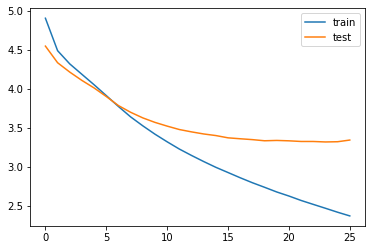

In [90]:
# 훈련데이터의 손실과 검증 데이터 손실이 줄어드는 과정 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [91]:
# 인퍼런스 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [92]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [93]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [94]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [95]:
## 모델 테스트

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

In [96]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : eight ipl spent crore buy players ipl auction jaipur tuesday kings xi punjab spent crore bought number players auction chennai super kings spent crore fill two available many players selected auction 
실제 요약 : crore spent for players in ipl auction 
예측 요약 :  crore spent in ipl auction of auction


원문 : electric across europe nearly six minutes behind since mid january due political dispute serbia power grid connected europe power network problem caused using electricity serbia responsibility grid 
실제 요약 : european lose over power 
예측 요약 :  launches for


원문 : paris opened first ever nude restaurant public friday guests asked remove clothes leave upon entering restaurant blocked views street meals remains open seats people start 
실제 요약 : paris opens its first ever restaurant 
예측 요약 :  video of


원문 : scientists identified oldest known animal shaped called based million year old fossils found coast white sea russia discovery confirmed organic remains fossils ancient study decades old

예측 요약 :  ceo passes down


원문 : amazon us employee allen claimed company go days without eating workplace accident allen said injured back job receive proper help amazon treatment amazon offered say anything derogatory company 
실제 요약 : amazon me days without eating employee 
예측 요약 :  startup founder to iphone


원문 : premier league clubs spent billion new players summer transfer window closed thursday liverpool biggest estimated million tottenham became first club fail make one summer signing last summer premier league clubs spent billion 
실제 요약 : league spent crore in 
예측 요약 :  indian origin wins crore in uae


원문 : group responsible hacking various social media accounts threatened leak game thrones season ahead air date also threatened release passwords number social media accounts hackers earlier released got scripts company data demanded undisclosed amount ransom nn 
실제 요약 : hackers to leak got season 
예측 요약 :  to media on media


원문 : great granddaughter netaji chandra bose bharat 

# Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.
Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 데이터 불러오기부터 다시

In [3]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
95792,"Blast in northwestern Pak kills at least 22, i...",A bomb blast in Pakistan's northwestern city o...
44077,NASA satellites recreate solar eruption in 3D,Scientists have combined data from three NASA ...
34304,Yeddyurappa's son not contesting against Karna...,"BY Vijayendra, son of BJP's Karnataka CM candi..."
8979,Six Lashkar terrorists killed in encounter in ...,At least six Lashkar-e-Taiba terrorists were k...
97270,Sexual desires depicted without creativity is ...,Actress Swara Bhaskar has said that eroticism ...
26384,Rejected B'wood films as I was asked to act wi...,Actor Diljit Dosanjh has revealed that he refu...
79940,16 private Noida schools get notice over empty...,As many as 16 private schools in Noida were se...
89391,"Disguised Putin must be new FBI chief, suggest...",After US President Donald Trump fired FBI Dire...
77405,SC imposes 100% penalty on firms mining illega...,The Supreme Court on Wednesday ordered mining ...
5431,I had thought of sending a text about Lyon to ...,Ex-India captain Sourav Ganguly has said he ha...


In [4]:
# contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
#                            "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
#                            "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
#                            "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
#                            "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
#                            "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
#                            "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
#                            "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
#                            "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
#                            "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
#                            "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
#                            "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
#                            "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
#                            "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
#                            "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
#                            "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
#                            "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
#                            "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
#                            "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
#                            "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
#                            "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
#                            "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
#                            "you're": "you are", "you've": "you have"}

In [5]:
# #데이터 전처리 함수
# def preprocess_sentence(sentence, remove_stopwords=True):
#     sentence = sentence.lower() # 텍스트 소문자화
#     sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
#     sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
#     sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
#     sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
#     sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
#     sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
#     # 불용어 제거 (Text)
#     if remove_stopwords:
#         tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
#     # 불용어 미제거 (Summary)
#     else:
#         tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
#     return tokens

In [6]:
# clean_text = []

# # 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
# for s in data['text']:
#     clean_text.append(preprocess_sentence(s))

# # 전처리 후 출력
# clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [7]:
# clean_summary = []

# # 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
# for s in data['headlines']:
#     clean_summary.append(preprocess_sentence(s, False))

# clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [8]:
# ## 전처리한 데이터를 원래 컬럼에 다시 넣어줍시다
# data['text'] = clean_text
# data['headlines'] = clean_summary


In [9]:
# # 빈 값을 Null 값으로 변환 --> 밑에서 Null을 또 없앤다
# data.replace('', np.nan, inplace=True)

In [10]:
# # null 유무 확인

# data.isnull().sum()

headlines    0
text         0
dtype: int64

In [5]:
from summa.summarizer import summarize

extra_text = data['text']

# 텍스트 확인
extra_text.head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: text, dtype: object

In [26]:
new_list = []
for x in extra_text :
    new_list.append(summarize(x, ratio=0.4))



In [27]:
print(new_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
for i in range(0, 100):
    print("원문 :", extra_text[i])
    print("요약 :", new_list[i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
요약 : Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


원문 : New Zealand defeated India by 8 wickets